In [121]:
import torch
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

In [122]:
# Choose GPU if available, otherwise fallback to CPU
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")
print(DEVICE)

cpu


In [ ]:
# Set variances for initial states
# variance2 = 10
# variance1 = 1 / variance2 # Inverse variance
variance2 = 10 ** 0.8
variance1 = 10 ** -0.5 # Inverse variance

N = 100  # Number of modes
total_sample_num = 100000  # Total number of samples

def beam_splitter_timeevolution(INmode1, INmode2, theta=np.pi/4):
    c = np.cos(theta)
    s = np.sin(theta)
    OUTmode1 = INmode1 * c - INmode2 * s
    OUTmode2 = INmode1 * c + INmode2 * s
    return OUTmode1, OUTmode2

def split_into_temporal_modes(samples, N, modes_space_num=0):
    sample_num_per_temporal_mode = samples.shape[0] // N - modes_space_num
    temporal_modes_samples = torch.zeros((sample_num_per_temporal_mode, N, 2)).to(DEVICE)
    for i in range(N):
        temporal_modes_samples[:, i, :] = samples[(sample_num_per_temporal_mode+modes_space_num)*i:(sample_num_per_temporal_mode+modes_space_num)*i+sample_num_per_temporal_mode, :]
    return temporal_modes_samples

def combine_temporal_modes(samples, modes_space_num=0):
    sample_num_per_temporal_mode = samples.shape[0]
    combined_samples = torch.zeros((sample_num_per_temporal_mode*(samples.shape[1]+modes_space_num), 2)).to(DEVICE)
    for i in range(samples.shape[1]):
        combined_samples[(sample_num_per_temporal_mode+modes_space_num)*i:(sample_num_per_temporal_mode+modes_space_num)*i+sample_num_per_temporal_mode, :] = samples[:, i, :]
    return combined_samples

def delay_line(samples, delay_num):
    delay_num = int(delay_num)
    shifted = torch.zeros_like(samples)
    if delay_num > 0:
        shifted[delay_num:] = samples[:-delay_num]
    elif delay_num < 0:
        shifted[:delay_num] = samples[-delay_num:]
    else:
        shifted = samples
    return shifted

```
mode0(...,4,2,0) -- ###### -- mode1(...,2,0) ----------- mode2(...,4,2,0) -- ###### -- mode3(...,6,4,2)
                    # BS #                                                   # BS #                    
mode0(...,5,3,1) -- ###### -- mode1(...,3,1) -- DELAY -- mode2(...,3,1,X) -- ###### -- mode3(...,5,3,1)
```

In [124]:
# Generate random initial sigle mode Gaussian state samples
initial0_mean = torch.zeros(2).to(DEVICE)
initial0_covariance = torch.diag(torch.tensor([variance1,variance2])).to(DEVICE)
initial1_mean = torch.zeros(2).to(DEVICE)
initial1_covariance = torch.diag(torch.tensor([variance2,variance1])).to(DEVICE)
initial0_samples = torch.distributions.multivariate_normal.MultivariateNormal(initial0_mean, initial0_covariance).sample((total_sample_num,)).to(DEVICE)
initial1_samples = torch.distributions.multivariate_normal.MultivariateNormal(initial1_mean, initial1_covariance).sample((total_sample_num,)).to(DEVICE)

In [125]:
# Split into temporal modes
sample_num_per_mode = total_sample_num // N 
mode0_samples = torch.zeros((sample_num_per_mode, N*2, 2)).to(DEVICE)
mode1_samples = torch.zeros((sample_num_per_mode, N*2, 2)).to(DEVICE)
mode2_samples = torch.zeros((sample_num_per_mode, N*2, 2)).to(DEVICE)
mode3_samples = torch.zeros((sample_num_per_mode, N*2, 2)).to(DEVICE)
for i in tqdm(range(0, N)):
    mode0_samples[:, 2*i,  :] = split_into_temporal_modes(initial0_samples, N, modes_space_num=0)[:, i, :]
    mode0_samples[:, 2*i+1,:] = split_into_temporal_modes(initial1_samples, N, modes_space_num=0)[:, i, :]

100%|██████████| 100/100 [00:00<00:00, 101.70it/s]


In [ ]:
# First beam splitter
# for i in tqdm(range(0, N)):
#     mode1_samples[:, 2*i, :] , mode1_samples[:, 2*i+1, :] = beam_splitter_timeevolution(mode0_samples[:, 2*i, :], mode0_samples[:, 2*i+1, :], theta=np.pi/4)
initial0_samples_mode1 = torch.zeros((total_sample_num, 2)).to(DEVICE)
initial1_samples_mode1 = torch.zeros((total_sample_num, 2)).to(DEVICE)
initial0_samples_mode1, initial1_samples_mode1 = beam_splitter_timeevolution(initial0_samples, initial1_samples, theta=np.pi/4)
# for i in tqdm(range(0, N)):
#     mode1_samples[:, 2*i,  :] = split_into_temporal_modes(initial0_samples_mode1, N, modes_space_num=0)[:, i, :]
#     mode1_samples[:, 2*i+1,:] = split_into_temporal_modes(initial1_samples_mode1, N, modes_space_num=0)[:, i, :]

# Delay
delay_num = sample_num_per_mode * 4
initial0_samples_mode2 = initial0_samples_mode1
initial1_samples_mode2 = delay_line(initial1_samples_mode1, delay_num=delay_num)

# Second beam splitter
# for i in tqdm(range(0, N)):
#     mode3_samples[:, 2*i, :] , mode3_samples[:, 2*i+1, :] = beam_splitter_timeevolution(mode2_samples[:, 2*i, :], mode2_samples[:, 2*i+1, :], theta=np.pi/4)
initial0_samples_mode3 = torch.zeros((total_sample_num, 2)).to(DEVICE)
initial1_samples_mode3 = torch.zeros((total_sample_num, 2)).to(DEVICE)
initial0_samples_mode3, initial1_samples_mode3 = beam_splitter_timeevolution(initial0_samples_mode2, initial1_samples_mode2, theta=np.pi/4)
for i in tqdm(range(0, N)):
    mode3_samples[:, 2*i,  :] = split_into_temporal_modes(initial0_samples_mode3, N, modes_space_num=0)[:, i, :]
    mode3_samples[:, 2*i+1,:] = split_into_temporal_modes(initial1_samples_mode3, N, modes_space_num=0)[:, i, :]

100%|██████████| 100/100 [00:00<00:00, 121.46it/s]


In [127]:
# Calculate nullifier: xA1+xB1+xA2-xB2 & pA1+pB1-pA2+pB2
def calculate_nullifierX(samples, s=0, e=N-2):
    nullifiers = []
    for i in tqdm(range(s, e)):
        nullifiers += [samples[:, 2*i+1, 0] + samples[:, 2*i, 0] + samples[:, 2*i+3, 0] - samples[:, 2*i+2, 0]]
    return nullifiers
def calculate_nullifierP(samples, s=0, e=N-2):
    nullifiers = []
    for i in tqdm(range(s, e)):
        nullifiers += [samples[:, 2*i+1, 1] + samples[:, 2*i, 1] - samples[:, 2*i+3, 1] + samples[:, 2*i+2, 1]]
    return nullifiers
print("Sample num per mode:", sample_num_per_mode, "\nDelay num: ", int(delay_num))

Sample num per mode: 1000 
Delay num:  4000


100%|██████████| 98/98 [00:00<00:00, 5686.56it/s]


13.146051217098625


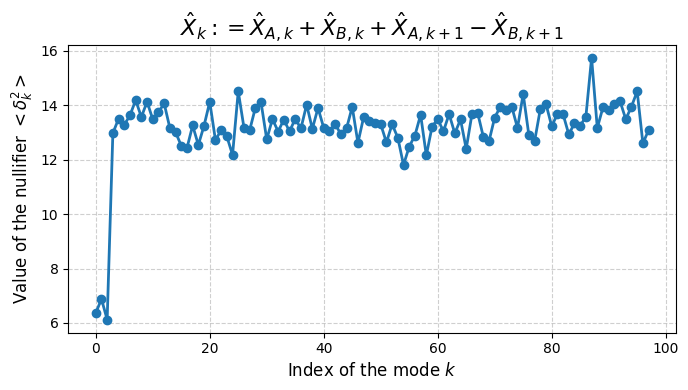

In [128]:
# Calculate all nullifier variances
result = [nullifier.clone().detach().var().item() for nullifier in calculate_nullifierX(mode3_samples, s=0, e=N-2)]

# (Optional) print average value
print(np.array(result).mean())

# Plot result with polished aesthetics
plt.figure(figsize=(7, 4))
plt.plot(result, linewidth=2, marker='o')
plt.title('$\hat{X}_k := \hat{X}_{A,k} + \hat{X}_{B,k} + \hat{X}_{A,k+1} - \hat{X}_{B,k+1}$', fontsize=16)
plt.xlabel(f"Index of the mode $k$", fontsize=12)
plt.ylabel(f"Value of the nullifier $<\\delta^2_k>$", fontsize=12)
# plt.ylim(0, 2)  # Set y-axis limits from 0 to 2
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

100%|██████████| 98/98 [00:00<00:00, 13999.58it/s]


13.105471109857364


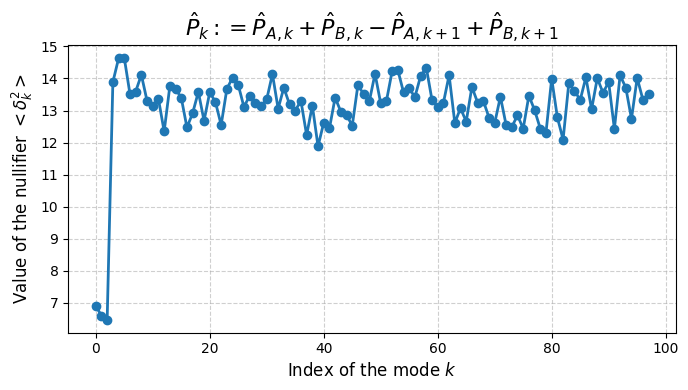

In [129]:
# Calculate all nullifier variances
result = [nullifier.clone().detach().var().item() for nullifier in calculate_nullifierP(mode3_samples)]

# (Optional) print average value
print(np.array(result).mean())

# Plot result with polished aesthetics
plt.figure(figsize=(7, 4))
plt.plot(result, linewidth=2, marker='o')
plt.title('$\hat{P}_k := \hat{P}_{A,k} + \hat{P}_{B,k} - \hat{P}_{A,k+1} + \hat{P}_{B,k+1}$', fontsize=16)
plt.xlabel(f"Index of the mode $k$", fontsize=12)
plt.ylabel(f"Value of the nullifier $<\\delta^2_k>$", fontsize=12)
# plt.ylim(0, 2)  # Set y-axis limits from 0 to 2
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()